In [1]:
%load_ext autoreload
%autoreload 2
import sympy as sp
from scipy.optimize import minimize, Bounds
from utils import *

In [2]:
dynamics = PlanarQuadrotorDynamicsWithInvertedPendulum(as_numpy=True)

# Planar Quadrotor - Direct Method

In [3]:
def pack_decision_variables(s, u, t_f = None, fixed_final_time = True):
    """Packs decision variables (final time, states, controls) into a 1D vector.
    
    Args:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    Returns:
        An array `z` of shape (1 + (N + 1) * s_dim + N * u_dim,).
    """
    if fixed_final_time:
        return np.concatenate([s.ravel(), u.ravel()])
    else:
        return np.concatenate([[t_f], s.ravel(), u.ravel()])

def unpack_decision_variables(z, fixed_final_time = True):
    """Unpacks a 1D vector into decision variables (final time, states, controls).
    
    Args:
        z: An array of shape (1 + (N + 1) * s_dim + N * u_dim,).
    Returns:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    """
    if fixed_final_time:
        s = z[0:(N + 1) * s_dim].reshape(N + 1, s_dim)
        u = z[-N * u_dim:].reshape(N, u_dim)
        return s, u
    else:
        t_f = z[0]
        s = z[1:1 + (N + 1) * s_dim].reshape(N + 1, s_dim)
        u = z[-N * u_dim:].reshape(N, u_dim)
        return t_f, s, u

In [4]:
d2r = np.pi/180
r2d = 180/np.pi

In [30]:
N = 60  # Number of time discretization nodes (0, 1, ... N).
s_dim = 8  # State dimension;
u_dim = 2  # Control dimension; 


# For fixed final time ONLY
t_f = 15  
dt = t_f/N

In [ ]:
def circle_traj(tf):
    T = tf
    t = np.linspace(0, T, N + 1)
    r = 2 # m
    w = 2*np.pi/T
    x = 2*np.cos(w*t)
    y = 2*np.sin(w*t)
    return x, y

In [31]:
def optimize_trajectory(z0 = None, max_iter=1000, fixed_final_time = True):
    #dynamics = PlanarQuadrotorDynamicsWithInvertedPendulum(as_numpy=True)
    
    circle = False
    sine = False
    
    def cost(z):
        if fixed_final_time:
            s, u = unpack_decision_variables(z, fixed_final_time)
            #if circle:
            #    x_des, y_des = circle_traj(t_f)
            #    x_actual = s[:,0]
            #    y_actual = s[:,1]
            #    return dt*(np.sum(np.square(u))+np.linalg.norm(x_des-x_actual)+np.linalg.norm(y_des-y_actual))
            
            return dt*np.sum(np.square(u))
        else:
            tf, s, u = unpack_decision_variables(z, fixed_final_time)
            
            return tf*0.5 + (tf/N)*np.sum(np.square(u))
            
    
    def constraints(z):
        if fixed_final_time:
            states, controls = unpack_decision_variables(z, fixed_final_time)
        else: 
            tf, states, controls = unpack_decision_variables(z, fixed_final_time)
        constraint_list = [states[0]-s_0, states[-1]-s_f]
        for i in range(N):
            if fixed_final_time:
                constraint_list.append(states[i+1]-(states[i]+(dt)*dynamics(states[i], None, controls[i])))
            else:
                constraint_list.append(states[i+1]-(states[i]+(tf/N)*dynamics(states[i], None, controls[i])))
        return np.concatenate(constraint_list)
    
    if fixed_final_time:
        z_guess = pack_decision_variables(np.linspace(s_0, s_f, N+1), np.ones((N, u_dim)), None, fixed_final_time)
    else:
        z_guess = pack_decision_variables(np.linspace(s_0, s_f, N+1), np.ones((N, u_dim)), 30, fixed_final_time)
        
    if z0 is not None:
        z_guess = z0
        
    z_iterates = [z_guess]

    if fixed_final_time:
        bnds = [(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]*(N+1) + [(0,np.inf),(0,np.inf)]*(N)
    else: 
        bnds = [(0, np.inf)] + [(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]*(N+1) + [(0,np.inf),(0,np.inf)]*(N)
    
    print("DEBUG: minimizing")
    
    result = minimize(cost,
                      z_guess,
                      method=None,
                      bounds=bnds,
                      constraints={'type':'eq','fun':constraints},
                      options={'maxiter':max_iter},
                      callback=lambda z:z_iterates.append(z))
    
    print("DEBUG: finish minimizing")
    
    print(result)
    
    z_iterates = np.stack(z_iterates)
    z = result.x
    return (unpack_decision_variables(z, fixed_final_time))

# Circle Trajectory

In [ ]:
s_0 = np.array([0, -2, 2*np.pi, np.pi-30*d2r, 0, 0, 0, 0])  # Initial state.
s_f = np.array([0, -2, 2*np.pi, np.pi, 0, 0, 0, 0])  # Final state.

In [ ]:
s, u = optimize_trajectory(max_iter=1000, fixed_final_time = True)

In [ ]:
t = np.linspace(0, t_f, N + 1)

In [ ]:
animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=True)

# (no control input limit)

In [ ]:
s_0 = np.array([0, 0, 2*np.pi, np.pi-30*d2r, 0, 0, 0, 0])  # Initial state.
s_f = np.array([5, 8, 2*np.pi, np.pi, 0, 0, 0, 0])  # Final state.

In [ ]:
t_f, s, u = optimize_trajectory(max_iter=1000, fixed_final_time = False)

In [ ]:
t = np.linspace(0, t_f, N + 1)

In [ ]:
animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=True)

In [ ]:
animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=True)

In [ ]:
#Now plot the position vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 1],'g',label='$y$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[0]*np.ones_like(t),'-.r',label='$x^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[1]*np.ones_like(t),'-.g',label='$y^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

In [ ]:
#Now plot the angle vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 2],'r',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 3],'g',label='$\\phi$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[2]*np.ones_like(t),'-.r',label='$\\theta^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[3]*np.ones_like(t),'-.g',label='$\\phi^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

In [ ]:
#Now plot the velocity vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 4],'r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 5],'g',label='$\\dot{y}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 6],'-.r',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 7],'-.g',label='$\\dot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

In [ ]:
#Now plot the control vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t[:-1],u[:, 0],'r',label='$T_1$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u[:, 1],'g',label='$T_2$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.r',label='$T1^*$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.g',label='$T2^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

# (control input limit > 0)

In [ ]:
s_0 = np.array([0, 0, 2*np.pi, np.pi-30*d2r, 0, 0, 0, 0])  # Initial state.
s_f = np.array([5, 8, 2*np.pi, np.pi, 0, 0, 0, 0])  # Final state.

In [ ]:
t_f, s, u = optimize_trajectory(max_iter=1000, fixed_final_time = False)

In [ ]:
t = np.linspace(0, t_f, N + 1)

In [ ]:
animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=True)

In [ ]:
ani = animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=False)
ani = ani.save('planar_quad_with_inverted_pendulum_fix_final_time_compare_LQR_2.mp4', writer='ffmpeg')

In [ ]:
T1 = u[:, 0]
T2 = u[:, 1]

x = s[:, 0]
y = s[:, 1]
θ = s[:, 2]
ϕ = s[:, 3]

data = {'t_f': t, 's': s, 'u': u}
save_dict(data, f'data/optimal_control.pkl')
maybe_makedirs('plots')

# plotting
# plt.rc('font', weight='bold', size=16)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'k-', linewidth=2)
plt.grid(True)
plt.plot(0, 0, 'go', markerfacecolor='green', markersize=15) # start position
plt.plot(5, 8, 'ro', markerfacecolor='red', markersize=15) # end position
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
#plt.axis([-1, 6, -1, 6])
plt.title(f'Optimal Control Trajectory')


plt.subplot(1, 2, 2)
plt.plot(t[:-1], T1, linewidth=2)
plt.plot(t[:-1], T2, linewidth=2)
plt.grid(True)
plt.xlabel('Time [s]')
plt.legend([r'$T_1$ [N]', r'$T_2$ [N]'], loc='best')
plt.title(f'Optimal control sequence')
plt.tight_layout()
#plt.savefig(f'plots/optimal_control_fix_time_3.png')
plt.show()


plt.figure(figsize=(12, 4))
#plt.subplot(1, 2, 2)
plt.plot(t, θ, linewidth=2)
plt.plot(t, ϕ, linewidth=2)
plt.grid(True)
plt.xlabel('Time [s]')
plt.legend([r'$\theta$ [rad]', r'$\phi$ [rad]'], loc='best')
plt.title(f'Angle')
plt.tight_layout()
plt.savefig(f'plots/planar_quad_with_inverted_pendulum_fix_final_time_compare_LQR_2.png')
plt.show()

# Plotting (control input limit > 0)

In [ ]:
#Now plot the position vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 1],'g',label='$y$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[0]*np.ones_like(t),'-.r',label='$x^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[1]*np.ones_like(t),'-.g',label='$y^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

In [ ]:
#Now plot the angle vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 2],'r',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 3],'g',label='$\\phi$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[2]*np.ones_like(t),'-.r',label='$\\theta^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[3]*np.ones_like(t),'-.g',label='$\\phi^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

In [ ]:
#Now plot the velocity vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 4],'r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 5],'g',label='$\\dot{y}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 6],'-.r',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 7],'-.g',label='$\\dot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

In [ ]:
#Now plot the control vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t[:-1],u[:, 0],'r',label='$T_1$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u[:, 1],'g',label='$T_2$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.r',label='$T1^*$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.g',label='$T2^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

# Swing Up Test 1

In [32]:
s_0 = np.array([0, 0, 0, 0, 0, 0, 0, 0])  # Initial state.
s_f = np.array([5, 8, 0, np.pi, 0, 0, 0, 0])  # Final state.

In [33]:
s, u = optimize_trajectory(max_iter=1000, fixed_final_time = True)

DEBUG: minimizing
DEBUG: finish minimizing
     fun: 135219.003381899
     jac: array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.       

In [ ]:
#s, u = optimize_trajectory(z0 = pack_decision_variables(s, u, None, fixed_final_time=True),max_iter=1000, fixed_final_time = True)

In [34]:
t = np.linspace(0, t_f, N + 1)

In [35]:
animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=True)

In [42]:
ani = animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=False)
ani = ani.save('planar_quad_with_inverted_pendulum_swing_up2.mp4', writer='ffmpeg')

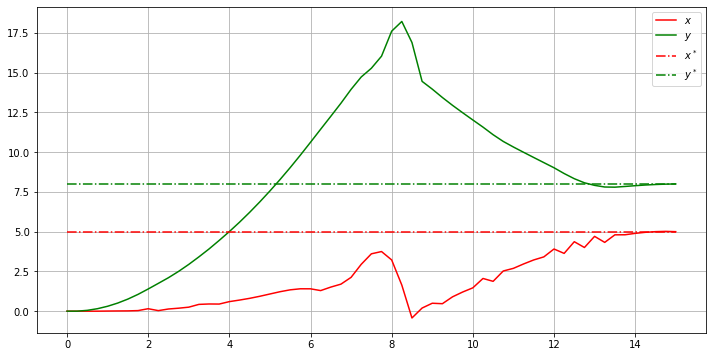

In [36]:
#Now plot the position vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 1],'g',label='$y$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[0]*np.ones_like(t),'-.r',label='$x^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[1]*np.ones_like(t),'-.g',label='$y^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

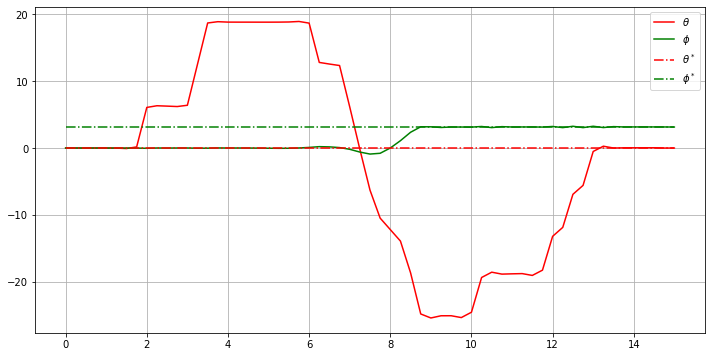

In [37]:
#Now plot the angle vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 2],'r',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 3],'g',label='$\\phi$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[2]*np.ones_like(t),'-.r',label='$\\theta^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[3]*np.ones_like(t),'-.g',label='$\\phi^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

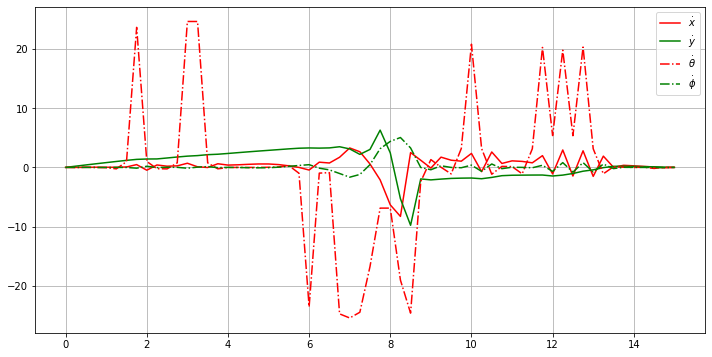

In [38]:
#Now plot the velocity vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 4],'r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 5],'g',label='$\\dot{y}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 6],'-.r',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 7],'-.g',label='$\\dot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

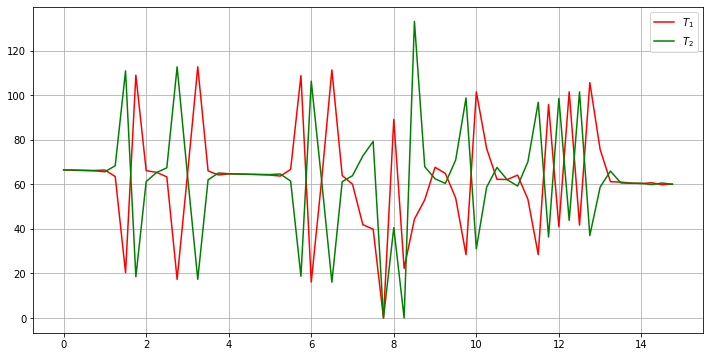

In [39]:
#Now plot the control vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t[:-1],u[:, 0],'r',label='$T_1$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u[:, 1],'g',label='$T_2$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.r',label='$T1^*$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.g',label='$T2^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

# Swing Up Test 2

In [43]:
N = 60  # Number of time discretization nodes (0, 1, ... N).

# For fixed final time ONLY
t_f = 15  
dt = t_f/N

In [44]:
s_0 = np.array([0, 0, 0, 0, 0, 0, 0, 0])  # Initial state.
s_f = np.array([0, 0, 0, np.pi, 0, 0, 0, 0])  # Final state.

In [45]:
s, u = optimize_trajectory(max_iter=1000, fixed_final_time = True)

DEBUG: minimizing
DEBUG: finish minimizing
     fun: 142432.08950751374
     jac: array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.     

In [46]:
t = np.linspace(0, t_f, N + 1)

In [47]:
animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=True)

In [48]:
ani = animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=False)
ani = ani.save('planar_quad_with_inverted_pendulum_swing_up3.mp4', writer='ffmpeg')

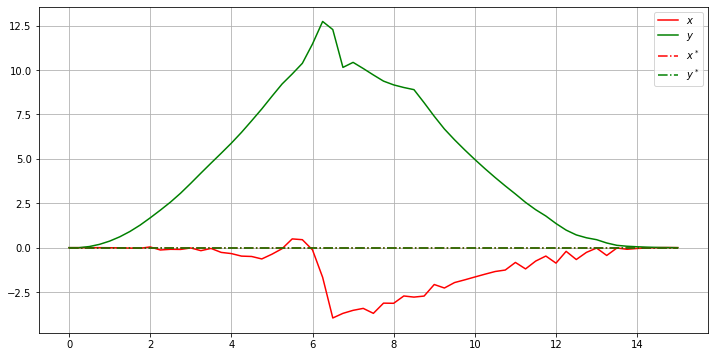

In [49]:
#Now plot the position vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 1],'g',label='$y$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[0]*np.ones_like(t),'-.r',label='$x^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[1]*np.ones_like(t),'-.g',label='$y^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

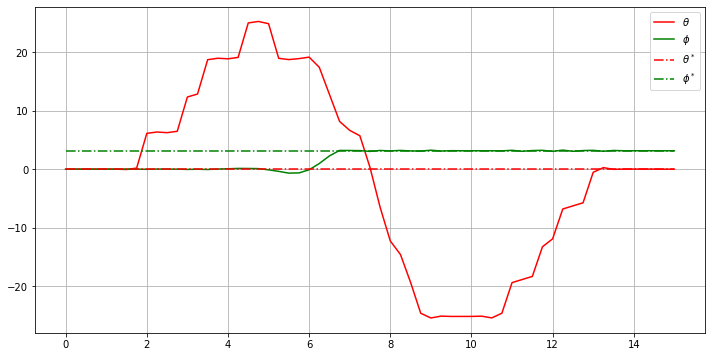

In [50]:
#Now plot the angle vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 2],'r',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 3],'g',label='$\\phi$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[2]*np.ones_like(t),'-.r',label='$\\theta^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s_f[3]*np.ones_like(t),'-.g',label='$\\phi^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

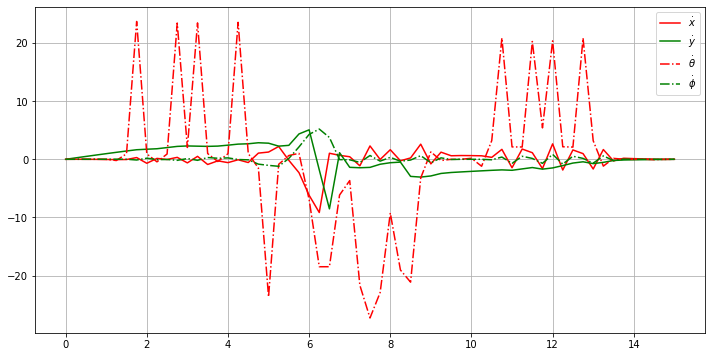

In [51]:
#Now plot the velocity vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s[:, 4],'r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 5],'g',label='$\\dot{y}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 6],'-.r',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s[:, 7],'-.g',label='$\\dot{\\phi}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

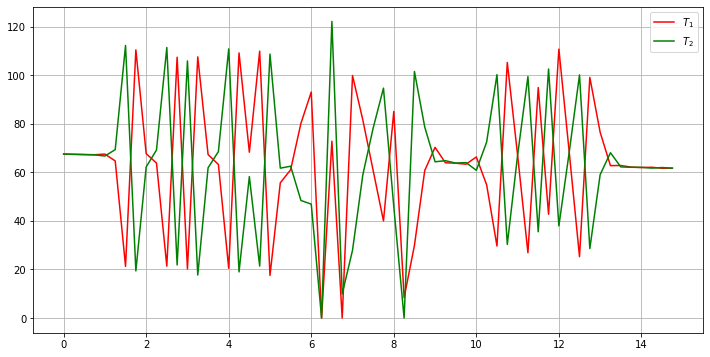

In [52]:
#Now plot the control vs time
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t[:-1],u[:, 0],'r',label='$T_1$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t[:-1],u[:, 1],'g',label='$T_2$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.r',label='$T1^*$') #Note: when using latex in legends, use double instead of single '\' for variables
#ax.plot(t[:-1],u_star[0]*np.ones_like(t[:-1]),'-.g',label='$T2^*$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here